In [2]:
import pandas as pd
import matplotlib.pylab as plt
from scipy.stats import shapiro
from scipy import stats

In [3]:
df = pd.read_csv('data/4000_complete_data.csv')

In [4]:
df.head()

,rank,lemma,PoS,freq,synonym,synset,random,synonym_similarity_left,synonym_similarity_right,synonym_similarity,random_similarity_left,random_similarity_right,random_similarity
0,26,say,v,4096416,tell,Synset('order.v.01'),blanket,0.792683,0.785402,0.789042,0.612346,0.621714,0.617030
1,31,go,v,3546732,start,Synset('start.v.09'),blank,0.718980,0.710389,0.714685,0.592116,0.595401,0.593759
2,34,get,v,3347615,acquire,Synset('get.v.01'),overhaul,0.764049,0.767176,0.765613,0.672227,0.664227,0.668227
3,39,know,v,2761628,recognise,Synset('acknowledge.v.06'),chisel,0.762813,0.771491,0.767152,0.694732,0.695436,0.695084
4,50,make,v,2290830,get,Synset('make.v.02'),tickle,0.758087,0.768161,0.763124,0.678154,0.688789,0.683472


In [5]:
df["synonym_similarity"] = (df["synonym_similarity_left"] + df["synonym_similarity_right"]) / 2
df["random_similarity"] = (df["random_similarity_left"] + df["random_similarity_right"]) / 2
eda_df = pd.concat([df['PoS'], df["synonym_similarity"], df["random_similarity"]], axis=1)

In [6]:
eda_df.head()

,PoS,synonym_similarity,random_similarity
0,v,0.789042,0.617030
1,v,0.714685,0.593759
2,v,0.765613,0.668227
3,v,0.767152,0.695084
4,v,0.763124,0.683472


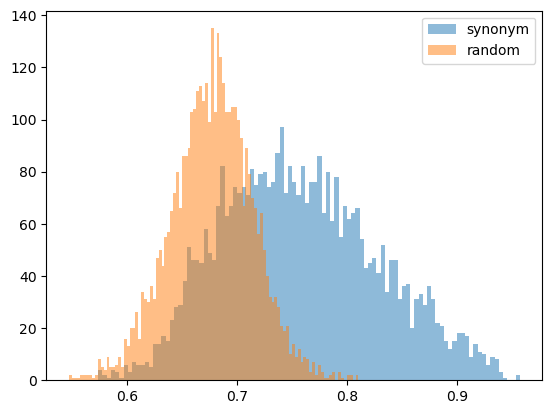

In [7]:
plt.hist(df["synonym_similarity"], bins = 100, alpha = 0.5, label="synonym")
plt.hist(df["random_similarity"], bins = 100, alpha = 0.5, label="random")
plt.legend()
plt.show()

### Hypothesis testing to discover the difference

In [8]:
# Check normality of two groups
shapiro_test_syn = shapiro(df["synonym_similarity"])
shapiro_test_rand = shapiro(df["random_similarity"])
print(shapiro_test_syn, shapiro_test_rand)

ShapiroResult(statistic=0.9901533722877502, pvalue=5.10387325664604e-16) ShapiroResult(statistic=0.9982354044914246, pvalue=0.00019567761046346277)


Two groups are not normally distributed, and the groups are independent. Use U-test to test if GPT has higher similarity on synonym than random pairs.

H0: Synonym pairs have equal similarity as random pairs.<br>
Ha: Synonym pairs have higher similarity than random pairs.

In [9]:
u_statistic, p_value = stats.mannwhitneyu(df["synonym_similarity"], df["random_similarity"], \
                                          alternative='greater')
print(u_statistic, p_value)

13271956.5 0.0


Test result is significant. We reject the null hypothesis, showing synonym pairs have higher similarity than random pairs.

### Difference between pairs' similarities group by PoS

In [10]:
df['PoS'].value_counts()

PoS
n    2231
v     900
a     639
r     212
Name: count, dtype: int64

We have different PoS group sizes in Synonym and Random pairs.

In [ ]:
# plt.hist(eda_df[eda_df['PoS'] == 'n']["synonym_similarity"], bins = 100, alpha = 0.5, label="n")
# plt.hist(eda_df[eda_df['PoS'] == 'v']["synonym_similarity"], bins = 100, alpha = 0.5, label="v")
# plt.hist(eda_df[eda_df['PoS'] == 'a']["synonym_similarity"], bins = 100, alpha = 0.5, label="a")
# plt.hist(eda_df[eda_df['PoS'] == 'r']["synonym_similarity"], bins = 100, alpha = 0.5, label="r")
# plt.legend()
# plt.show()

#### Difference between similarities group by PoS (Synonym pairs)

In [12]:
# Check normality
shapiro_test_syn_n = shapiro(eda_df[eda_df['PoS'] == 'n']["synonym_similarity"])
print(shapiro_test_syn_n)

ShapiroResult(statistic=0.9913840293884277, pvalue=3.019094418910129e-10)


Violate normality. Use Kruskal-Wallis test.

H0: In synonym pairs, there is no difference of similarity across PoS.<br>
Ha: There are differences.

In [13]:
from scipy.stats import kruskal

grouped_syn = [eda_df[eda_df['PoS'] == pos]['synonym_similarity'] for pos in eda_df['PoS'].unique()]
h_statistic, p_value = kruskal(*grouped_syn)

print(h_statistic, p_value)

72.40530599280669 1.3034409000510606e-15


P-value smaller than 0.05. Reject the null. There are differences.<br><br>
Let's find out which groups are different.

In [14]:
import scikit_posthocs as sp

dunn_test_results = sp.posthoc_dunn(eda_df, val_col='synonym_similarity', group_col='PoS', p_adjust='bonferroni')

print(dunn_test_results)

              a             n             r             v
a  1.000000e+00  1.000000e+00  1.975867e-01  8.377589e-09
n  1.000000e+00  1.000000e+00  3.795940e-02  2.592166e-12
r  1.975867e-01  3.795940e-02  1.000000e+00  1.589827e-09
v  8.377589e-09  2.592166e-12  1.589827e-09  1.000000e+00


There are differences in (a vs v), (n vs r), (n vs v), (r vs v).

Since the Kruskal-Wallis and Dunn’s tests are non-parametric tests based on ranks, we want to look at median similarities for each PoS.

In [15]:
median_similarity_syn = eda_df.groupby('PoS')['synonym_similarity'].median().sort_values(ascending=False)
median_similarity_syn

PoS
r    0.767477
n    0.757765
a    0.754154
v    0.735873
Name: synonym_similarity, dtype: float64

Results show that r (adverbs) has the highest median similarity, followed by n (nouns), a (adjectives), and v (verbs). It indicates that when scoring similarity in synonym word pairs, GPT would give adverbs with higher scores and verbs with lower ones.

In [16]:
type(median_similarity_syn)

pandas.core.series.Series

#### Difference of median similarity scores between synonym pairs and random pairs (by PoS)

Let's calculate the median similarity scores for random pairs by PoS and compare them to synonym pairs'.

In [18]:
median_similarity_rand = eda_df.groupby('PoS')['random_similarity'].median().sort_values(ascending=False)
median_similarity_rand

PoS
r    0.689306
a    0.685131
n    0.677237
v    0.673023
Name: random_similarity, dtype: float64

In [20]:
median_diff = (median_similarity_syn - median_similarity_rand).sort_values(ascending=False)
median_diff

PoS
n    0.080529
r    0.078171
a    0.069023
v    0.062850
dtype: float64

We can see that among 4 PoS from synonym pairs and random pairs, GPT gives the largest difference for n and smallest difference for v.

### Relationship between lemma frequency and similarity score

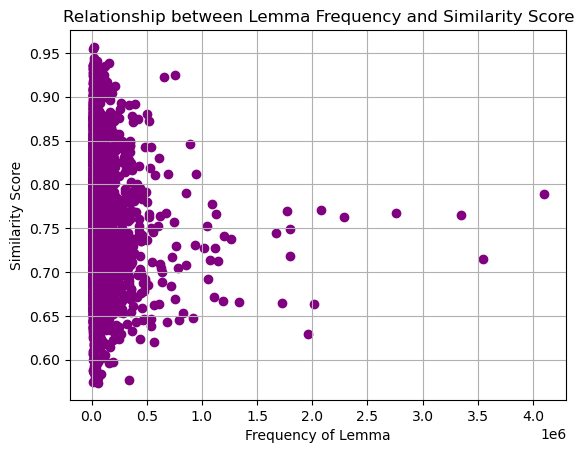

In [24]:
plt.scatter(df['freq'], eda_df['synonym_similarity'], color='purple')
plt.title('Relationship between Lemma Frequency and Similarity Score')
plt.xlabel('Frequency of Lemma')
plt.ylabel('Similarity Score')
plt.grid(True)
plt.show()

In [23]:
correlation_coefficient, p_value = stats.pearsonr(df['freq'], eda_df['synonym_similarity'])
print(correlation_coefficient, p_value)

-0.059512106910945425 0.0001715855354219396


Correlation corfficient of -0.0595 shows a very weak negative correlation. Although p-value is less than 0.05, the scatterplot shows no linear relationship between lemma frequency and similarity score.